In [17]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt

# Meta-learning the Dataset

## Setup

In [18]:
from evosax import OpenES, ParameterReshaper

env_name = "FourRooms-misc"

config = {
    "LR": 5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 512,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 40,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",
    "WIDTH" : 64,
    "ENV_NAME": env_name,
    "ANNEAL_LR": True,
    "GREEDY_ACT": False,  # Whether to use greedy act in env or sample
    "ENV_PARAMS" : {
        "fail_prob" : 0.02
    }
}

env, env_params = gymnax.make(env_name, use_visual_obs=False)
env_params = env_params.replace(**config["ENV_PARAMS"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": n_actions * 1, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
    "n_generations": 100,
    "log_interval": 5,
}

params = jnp.zeros(
    (es_config["dataset_size"], *env.observation_space(env_params).shape)
)
param_reshaper = ParameterReshaper(params)

rng = jax.random.PRNGKey(0)

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 16 parameters detected for optimization.


## Sampling real data

In [13]:
from tqdm import tqdm
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)

# obs_list = []
# action_list = []
# dones_list = []

# # Small chance of not gathering enough data, but it doesn't matter in practice
# for t in tqdm(range(es_config["dataset_size"] * 10)):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
#     action = jax.random.choice(rng_act, a=jnp.arange(n_actions))
#     action_list.append(action.item())
    
#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     obs_list.append(obs)    
    
# action_list = jnp.array(action_list)
# obs_list = jnp.array(obs_list)

# dataset = []
# for a in range(n_actions):
#     obs_for_action = obs_list[action_list == a]
#     rng, rng_shuffle = jax.random.split(rng)
#     dataset.append(jax.random.shuffle(rng_shuffle, obs_for_action, axis=0)[0:es_config["dataset_size"]//n_actions])
    
# sampled_data = jnp.array(dataset).flatten()
# print(sampled_data.shape)

# print(sampled_data.reshape(2,4))

## Initialize Strategy

In [14]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)

es_params = strategy.default_params
# es_params = es_params.replace(init_max=10.0)
state = strategy.initialize(rng_init, es_params)


def get_action_labels(d_size, n_actions):
    action_labels = jnp.array([i % n_actions for i in range(d_size)])
    action_labels = action_labels.sort()
    return action_labels


# Set up vectorized fitness function
train_fn = make_train(config)
action_labels = get_action_labels(es_config["dataset_size"], n_actions)


def single_seed_BC(rng_input, dataset):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0)))  # Vectorize over datasets

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))

## Run OpenES loop

In [15]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets)
        out = train_and_eval(batch_rng, shaped_datasets)

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Fitness is cumulative return over 512 steps, averaged over rollouts and envs
        # This is necessary since FourRooms has no penalty for finding the goal in many steps
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / (es_config["rollouts_per_candidate"] * config["NUM_ENVS"]) #/ dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices

    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC acc: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Gen: 0, Fitness: 0.01 +/- 0.05, Best: 0.89, BC loss: 0.02 +/- 0.10, BC acc: 0.99 +/- 0.04, Lap time: 4.7s
Gen: 5, Fitness: 0.83 +/- 0.25, Best: 1.66, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.4s
Gen: 10, Fitness: 0.99 +/- 0.22, Best: 1.66, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.4s
Gen: 15, Fitness: 1.00 +/- 0.18, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.2s
Gen: 20, Fitness: 0.96 +/- 0.14, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.2s
Gen: 25, Fitness: 1.04 +/- 0.22, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.3s
Gen: 30, Fitness: 0.95 +/- 0.21, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.3s
Gen: 35, Fitness: 1.02 +/- 0.13, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.3s
Gen: 40, Fitness: 0.99 +/- 0.14, Best: 1.71, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 6.3s
Gen: 45, Fitness: 1.05 +/- 0.13, Best: 

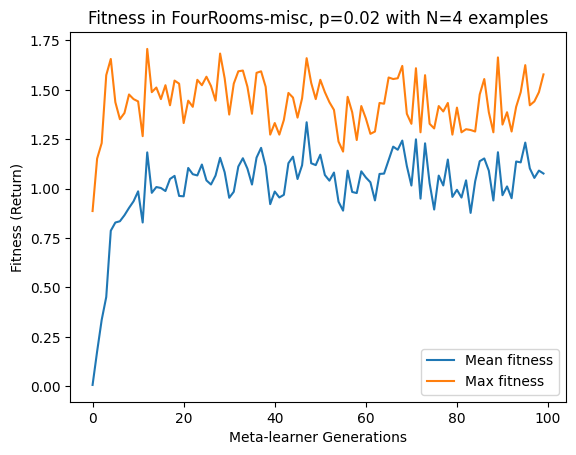

In [16]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in {config['ENV_NAME']}, p={config['ENV_PARAMS']['fail_prob']} with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

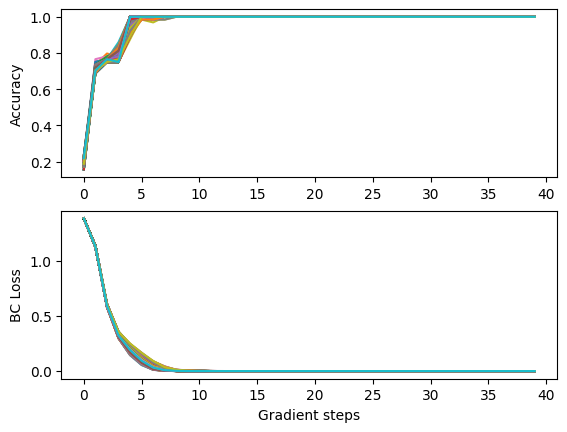

In [19]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")
    

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

In [20]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))

final_gen_dataset = final_datasets_reshaped[best_idx]
# final_dataset = final_gen_dataset
final_dataset = state.best_member

final_dataset = final_dataset.reshape(final_gen_dataset.shape)

print("Final dataset:")
print(final_dataset)

Final dataset:
[[-0.3077113  -0.06033682 -0.23897025  0.18844752]
 [-0.21433476 -0.3095708   0.3604658   0.21940136]
 [ 0.04107637  0.3436863   0.15115716 -0.2385284 ]
 [-0.2700981   0.22679488 -0.35999706 -0.12627596]]


In [21]:
best_returns = returns[best_idx]
best_dones = dones[best_idx]

# want returns on episodes on which we finish:
import numpy as np
cand_ret = np.zeros((16,16))

for i in range(16):
    for j in range(16):
        if best_dones[i,:,j].sum() > 0:
            cand_ret[i,j] = best_returns[i,:,j][best_dones[i,:,j]].sum()
            
cand_ret

print("Network returns (mean across envs):")
print(cand_ret.mean(1))

print("Envs returns (mean across networks):")
print(cand_ret.mean(0))


Network returns (mean across envs):
[1.4375 0.875  0.75   0.75   2.0625 1.5    1.6875 1.5625 1.8125 2.5
 1.125  2.125  1.8125 1.75   1.9375 1.5625]
Envs returns (mean across networks):
[1.3125 1.8125 2.625  1.375  1.1875 1.6875 1.3125 1.625  1.     1.625
 0.875  1.4375 2.     1.5    2.     1.875 ]


In [22]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret*best_dones).sum(axis=(1,2)) / config["NUM_ENVS"]
print("Best mean return per rollout \n", best_mean_ret)

Best mean return per rollout 
 [1.4375 0.875  0.75   0.75   2.0625 1.5    1.6875 1.5625 1.8125 2.5
 1.125  2.125  1.8125 1.75   1.9375 1.5625]


In [ ]:
test_returns = []

for i in tqdm(range(es_config["rollouts_per_candidate"])):
    g = lambda x : x[best_idx[0], best_idx[1], i]
    best_params = jax.tree_util.tree_map(g, train_state.params)

    env, env_params = gymnax.make(config["ENV_NAME"])
    env_params = env_params.replace(**config["ENV_PARAMS"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    n_actions = env.action_space(env_params).n

    rng = jax.random.PRNGKey(42)
    rng, reset_rng = jax.random.split(rng)
    obs, env_state = env.reset(reset_rng, env_params)

    rewards_per_ep = []
    ret = 0

    for t in range(256):
        rng, rng_act, rng_step = jax.random.split(rng, 3)

        pi = train_state.apply_fn(best_params, obs)
        action = pi.argmax(axis=-1)

        obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
        rewards_per_ep.append(reward)
        if done:
            ep_ret = jnp.array(rewards_per_ep).sum()
            rewards_per_ep = []
            ret += reward.item()
            
    test_returns.append(ret)

print("returns: ", test_returns)

In [ ]:
# SEE POLICY PLAY

# reg_env, env_params = gymnax.make(config["ENV_NAME"])
# env = FlattenObservationWrapper(env)

# env_params = env_params.replace(fail_prob=0)

# n_actions = env.action_space(env_params).n

# rng = jax.random.PRNGKey(42)
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)
# _, reg_env_state = reg_env.reset(reset_rng, env_params)
# img, ax = env.render(reg_env_state, env_params)

# rewards_per_ep = []

# for t in range(10):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
    
#     pi = train_state.apply_fn(best_params, obs)
#     action = pi.argmax(axis=-1)

#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     _, reg_env_state, _, _, _ = reg_env.step(rng_step, reg_env_state, action, env_params)
    
#     img, ax = env.render(reg_env_state, env_params)
    
#     rewards_per_ep.append(reward)
#     if done:
#         ep_ret = jnp.array(rewards_per_ep).sum()
#         print("Ep return: ", ep_ret)
#         rewards_per_ep = []


[-0.3077113  -0.06033682 -0.23897025  0.18844752]
[-0.21433476 -0.3095708   0.3604658   0.21940136]
[ 0.04107637  0.3436863   0.15115716 -0.2385284 ]
[-0.2700981   0.22679488 -0.35999706 -0.12627596]


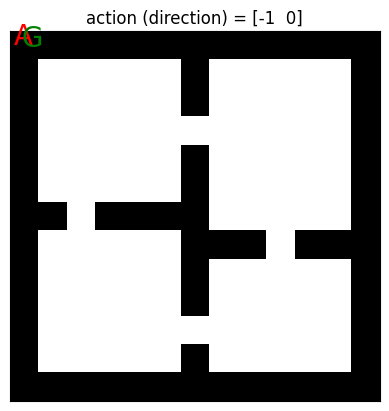

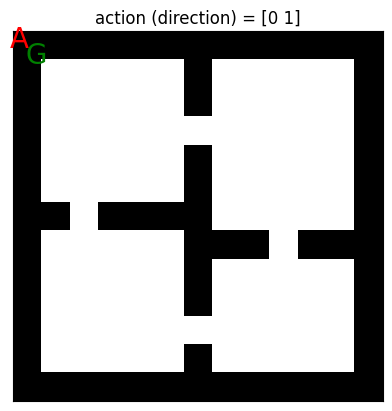

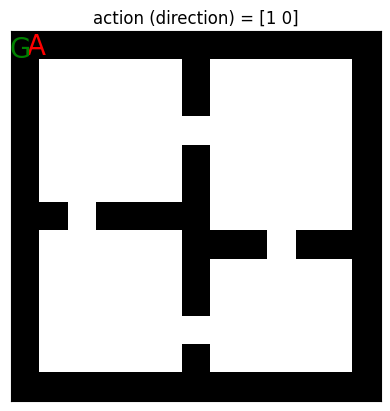

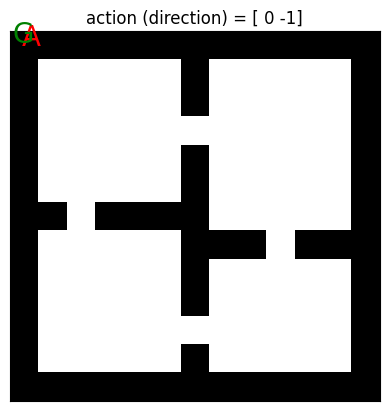

In [23]:
from policy_distillation.render import render_fourrooms as render_fn
# fig, ax = plt.subplots(1,n_actions, figsize=(12,8))

env_name = "FourRooms-misc"
env, env_params = gymnax.make(env_name)

rng_env = jax.random.PRNGKey(1)
obs, env_state = env.reset(rng_env)

for i, synth_obs in enumerate(final_dataset):
    
    synth_state = env_state.replace(pos=synth_obs[:2], goal=synth_obs[2:])
    img, ax = render_fn(synth_state, env_params)
    
    ax.set_title(f"action (direction) = {env.directions[i]}")
    
#     img.show()
    
#     ax[i].imshow(img, label="hello")
#     ax[i].set_title(f"action = {action_labels[i]}")
    
#     theta_dot1 = synth_state[-2].item()
#     theta_dot2 = synth_state[-1].item()
    
    print(synth_obs)
    
# #     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
#     ax[i].text(330, 70, f"dθ1={theta_dot1:.2f} \ndθ2={theta_dot2:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [24]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = 10
    num_envs = 20
    
    transfer_fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

        final_dataset # Given
        action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset)

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
#         transfer_fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2)) 
        transfer_fitness[activation] = (returns * dones).sum(axis=(-1, -2)) / num_envs
        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(transfer_fitness[activation])
    
    print(f"Width {width} : transfer_fitness (relu)={transfer_fitness['relu'].mean():.1f} +/- {transfer_fitness['relu'].std():.1f}, "
         + f"transfer_fitness (tanh)={transfer_fitness['tanh'].mean():.1f} +/- {transfer_fitness['tanh'].std():.1f}")
    

/private/home/alupu/.conda/envs/exp-env/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:795: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Width 2 : transfer_fitness (relu)=0.4 +/- 0.5, transfer_fitness (tanh)=0.6 +/- 0.6
Width 4 : transfer_fitness (relu)=0.3 +/- 0.5, transfer_fitness (tanh)=0.9 +/- 1.0
Width 8 : transfer_fitness (relu)=0.3 +/- 0.4, transfer_fitness (tanh)=0.4 +/- 0.9
Width 16 : transfer_fitness (relu)=0.6 +/- 0.8, transfer_fitness (tanh)=0.3 +/- 0.4
Width 32 : transfer_fitness (relu)=0.3 +/- 0.3, transfer_fitness (tanh)=0.5 +/- 0.5
Width 64 : transfer_fitness (relu)=0.7 +/- 0.4, transfer_fitness (tanh)=0.4 +/- 0.4
Width 128 : transfer_fitness (relu)=0.8 +/- 0.4, transfer_fitness (tanh)=0.5 +/- 0.5
Width 256 : transfer_fitness (relu)=1.1 +/- 0.5, transfer_fitness (tanh)=0.3 +/- 0.3
Width 512 : transfer_fitness (relu)=0.7 +/- 0.4, transfer_fitness (tanh)=0.2 +/- 0.3
Width 1024 : transfer_fitness (relu)=0.9 +/- 0.5, transfer_fitness (tanh)=0.4 +/- 0.6


In [ ]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)
plt.title(f"Dataset transfer (original: {config['ACTIVATION']}{config['WIDTH']} )")
plt.legend()
plt.show()

In [ ]:
fit_list["relu"][5].std()